# Investment Risk and Returns

In [1]:
!python --version

Python 3.7.11


In [2]:
# import packages

import pandas as pd
import numpy as np
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import date
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
plt.style.use('fivethirtyeight')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
#import datasets

amazon = pd.read_csv('dataset/AMAZON_HistoricalData.csv', parse_dates=['Date'])
apple = pd.read_csv('dataset/APPLE_HistoricalData.csv', parse_dates=['Date'])
baba = pd.read_csv('dataset/BABA_HistoricalData.csv', parse_dates=['Date'])
tesla = pd.read_csv('dataset/TESLA_HistoricalData.csv', parse_dates=['Date'])
tqqq = pd.read_csv('dataset/TQQQ_HistoricalData.csv', parse_dates=['Date'])

In [4]:
amazon.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,$3152.79,12672790,$3112.13,$3224,$3012.16
1,2022-02-03,$2776.91,11276570,$2834.75,$2884.95,$2766.66
2,2022-02-02,$3012.25,4366488,$3101.0085,$3101.5,$2977.2717
3,2022-02-01,$3023.87,2960992,$3000,$3034.16,$2952.5548
4,2022-01-31,$2991.47,3915372,$2895,$3007.21,$2886.0101


In [5]:
apple.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,$172.39,82465400,$171.68,$174.1,$170.68
1,2022-02-03,$172.9,89418070,$174.48,$176.2399,$172.12
2,2022-02-02,$175.84,84914260,$174.745,$175.88,$173.33
3,2022-02-01,$174.61,86213910,$174.01,$174.84,$172.31
4,2022-01-31,$174.78,115541600,$170.16,$175,$169.51


In [6]:
baba.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,$122.22,13538230,$121.27,$123.94,$119.66
1,2022-02-03,$123.47,16651450,$121.55,$125.27,$120.73
2,2022-02-02,$122.88,14050110,$127.63,$127.63,$121.17
3,2022-02-01,$127.22,15036090,$124.81,$128,$122.97
4,2022-01-31,$125.79,20346450,$118.17,$125.87,$117.5


In [7]:
tesla.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,$923.32,24541820,$897.22,$936.5,$881.17
1,2022-02-03,$891.14,26285190,$882,$937,$880.52
2,2022-02-02,$905.66,22264350,$928.18,$931.5,$889.41
3,2022-02-01,$931.25,24379450,$935.21,$943.7,$905
4,2022-01-31,$936.72,34812030,$872.71,$937.99,$862.05


In [8]:
tqqq.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,58.70,96534410,56.870,60.4100,55.89
1,2022-02-03,56.74,105575000,59.320,61.0700,56.12
2,2022-02-02,64.50,100815200,65.220,65.3697,62.35
3,2022-02-01,63.01,101845800,62.420,63.3500,59.73
4,2022-01-31,61.83,113751100,57.045,62.0599,56.22


In [9]:
tqqq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1259 non-null   datetime64[ns]
 1   Close/Last  1259 non-null   float64       
 2   Volume      1259 non-null   int64         
 3   Open        1259 non-null   float64       
 4   High        1259 non-null   float64       
 5   Low         1259 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


## Wrangling and Cleaning

In [10]:
#replace $ chars and change to float

cols = ['Close/Last', 'Open', 'High', 'Low']

for col in cols:
    amazon[col] = amazon[col].str.replace('$', '').astype(float)
    apple[col] = apple[col].str.replace('$', '').astype(float)
    baba[col] = baba[col].str.replace('$', '').astype(float)
    tesla[col] = tesla[col].str.replace('$', '').astype(float)

In [11]:
amazon.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,3152.79,12672790,3112.1300,3224.00,3012.1600
1,2022-02-03,2776.91,11276570,2834.7500,2884.95,2766.6600
2,2022-02-02,3012.25,4366488,3101.0085,3101.50,2977.2717
3,2022-02-01,3023.87,2960992,3000.0000,3034.16,2952.5548
4,2022-01-31,2991.47,3915372,2895.0000,3007.21,2886.0101


In [12]:
apple.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,172.39,82465400,171.680,174.1000,170.68
1,2022-02-03,172.90,89418070,174.480,176.2399,172.12
2,2022-02-02,175.84,84914260,174.745,175.8800,173.33
3,2022-02-01,174.61,86213910,174.010,174.8400,172.31
4,2022-01-31,174.78,115541600,170.160,175.0000,169.51


In [13]:
baba.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,122.22,13538230,121.27,123.94,119.66
1,2022-02-03,123.47,16651450,121.55,125.27,120.73
2,2022-02-02,122.88,14050110,127.63,127.63,121.17
3,2022-02-01,127.22,15036090,124.81,128.00,122.97
4,2022-01-31,125.79,20346450,118.17,125.87,117.50


In [14]:
tesla.head()

,Date,Close/Last,Volume,Open,High,Low
0,2022-02-04,923.32,24541820,897.22,936.50,881.17
1,2022-02-03,891.14,26285190,882.00,937.00,880.52
2,2022-02-02,905.66,22264350,928.18,931.50,889.41
3,2022-02-01,931.25,24379450,935.21,943.70,905.00
4,2022-01-31,936.72,34812030,872.71,937.99,862.05


In [15]:
display(amazon.dtypes)
display(apple.dtypes)
display(baba.dtypes)
display(tesla.dtypes)
display(tqqq.dtypes)

Date          datetime64[ns]
Close/Last           float64
Volume                 int64
Open                 float64
High                 float64
Low                  float64
dtype: object

Date          datetime64[ns]
Close/Last           float64
Volume                 int64
Open                 float64
High                 float64
Low                  float64
dtype: object

Date          datetime64[ns]
Close/Last           float64
Volume                 int64
Open                 float64
High                 float64
Low                  float64
dtype: object

Date          datetime64[ns]
Close/Last           float64
Volume                 int64
Open                 float64
High                 float64
Low                  float64
dtype: object

Date          datetime64[ns]
Close/Last           float64
Volume                 int64
Open                 float64
High                 float64
Low                  float64
dtype: object

### check the null values

In [16]:
display(amazon.isnull().any())
display(apple.isnull().any())
display(baba.isnull().any())
display(tesla.isnull().any())
display(tqqq.isnull().any())

Date          False
Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

Date          False
Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

Date          False
Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

Date          False
Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

Date          False
Close/Last    False
Volume        False
Open          False
High          False
Low           False
dtype: bool

### Creating df portfolio

In [17]:
amazon.set_index(['Date'], inplace = True)
apple.set_index(['Date'], inplace = True)
baba.set_index(['Date'], inplace = True)
tesla.set_index(['Date'], inplace = True)
tqqq.set_index(['Date'], inplace = True)

In [18]:
amazon.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2022-02-04,3152.79,12672790,3112.1300,3224.00,3012.1600
2022-02-03,2776.91,11276570,2834.7500,2884.95,2766.6600
2022-02-02,3012.25,4366488,3101.0085,3101.50,2977.2717
2022-02-01,3023.87,2960992,3000.0000,3034.16,2952.5548
2022-01-31,2991.47,3915372,2895.0000,3007.21,2886.0101


In [19]:
amazon_copy = amazon[['Close/Last']].rename(columns = {'Close/Last': 'Amazon'})
apple_copy = apple[['Close/Last']].rename(columns = {'Close/Last': 'Apple'})
baba_copy = baba[['Close/Last']].rename(columns = {'Close/Last': 'Alibaba'})
tesla_copy = tesla[['Close/Last']].rename(columns = {'Close/Last': 'Tesla'})
tqqq_copy = tqqq[['Close/Last']].rename(columns = {'Close/Last': 'TQQQ'})

In [20]:
prices =pd.concat([amazon_copy,apple_copy,baba_copy,tesla_copy,tqqq_copy], axis = 1)
prices.head()

,Amazon,Apple,Alibaba,Tesla,TQQQ
Date,,,,,
2022-02-04,3152.79,172.39,122.22,923.32,58.70
2022-02-03,2776.91,172.90,123.47,891.14,56.74
2022-02-02,3012.25,175.84,122.88,905.66,64.50
2022-02-01,3023.87,174.61,127.22,931.25,63.01
2022-01-31,2991.47,174.78,125.79,936.72,61.83


In [21]:
print('Data Inicio', prices.index.min())
print('Data Fim', prices.index.max())

Data Inicio 2017-02-07 00:00:00
Data Fim 2022-02-04 00:00:00


---

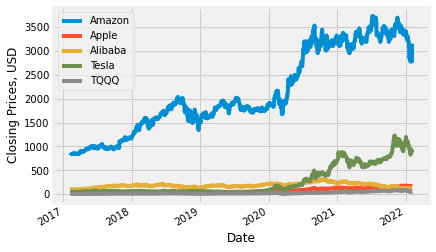

<Figure size 864x576 with 0 Axes>

In [22]:
#plot 
prices.plot().set_ylabel("Closing Prices, USD")
plt.figure(figsize = (12,8))
plt.show()

# Frontier Efficient (MPT)

### Step 1 - Historical Returns

In [23]:
#  mean historical return
mu = expected_returns.mean_historical_return(prices)
mu

Amazon    -0.237854
Apple     -0.282434
Alibaba   -0.037805
Tesla     -0.439100
TQQQ      -0.358894
dtype: float64

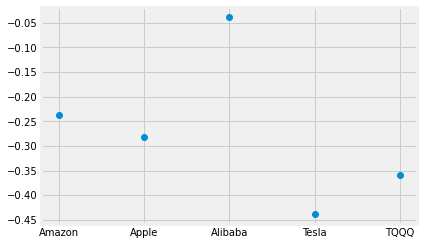

In [24]:
# Plot the annualized average historical return
plt.plot(mu, linestyle = 'None', marker = 'o')
plt.show()

### Step 2 - Covariance

In [25]:
#instace covariance object
S = CovarianceShrinkage(prices).ledoit_wolf()

print("Efficient Covariance Matrix \n", S)

Efficient Covariance Matrix 
            Amazon     Apple   Alibaba     Tesla      TQQQ
Amazon   0.095213  0.057447  0.049981  0.068693  0.160821
Apple    0.057447  0.097801  0.047768  0.079368  0.179415
Alibaba  0.049981  0.047768  0.139274  0.067222  0.133694
Tesla    0.068693  0.079368  0.067222  0.372809  0.227001
TQQQ     0.160821  0.179415  0.133694  0.227001  0.493606


Covariance between daily simple returns of stocks in your portfolio



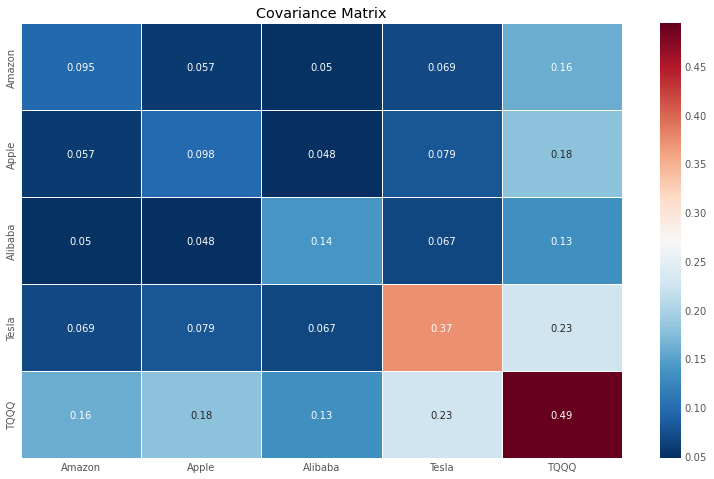

In [26]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (12,8))
ax = sb.heatmap(S,xticklabels=S.columns, yticklabels=S.columns,
cmap='RdBu_r', annot=True, linewidth=0.5)
ax.set_title('Covariance Matrix')
print('Covariance between daily simple returns of stocks in your portfolio\n')
plt.show()

### Step 3 - Critical Line Algorithm

Disclaimer from <a href = 'https://pyportfolioopt.readthedocs.io/en/latest/OtherOptimizers.html?highlight=CLA#the-critical-line-algorithm'>documentation</a>:

"This is a robust alternative to the quadratic solver used to find mean-variance optimal portfolios, that is especially advantageous when we apply linear inequalities. Unlike generic convex optimization routines, the CLA is specially designed for portfolio optimization. It is guaranteed to converge after a certain number of iterations, and can efficiently derive the entire efficient frontier."

<img src = 'https://pyportfolioopt.readthedocs.io/en/latest/_images/cla_plot.png'>

In [27]:
# CLA object

ep = CLA(mu, S)

# Minimum volatility
ep.min_volatility()

OrderedDict([('Amazon', 0.38744004702711976),
             ('Apple', 0.3755867185838433),
             ('Alibaba', 0.23697323438903697),
             ('Tesla', 0.0),
             ('TQQQ', 0.0)])

In [28]:
# Compute the efficient frontier
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('Amazon', 1.0), ('Apple', 1.0), ('Alibaba', 1.0), ('Tesla', -1.0), ('TQQQ', -1.0)])


In [29]:
ef.portfolio_performance(verbose=True)

Expected annual return: 24.0%
Annual volatility: 76.5%
Sharpe Ratio: 0.29


(0.2399003261713264, 0.7646383771079874, 0.2875873520801201)

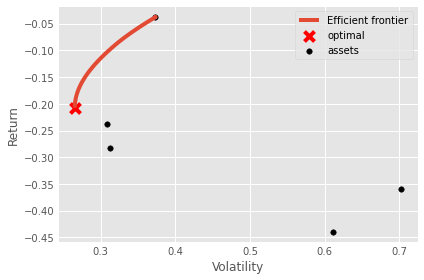

In [30]:
ax = pplt.plot_efficient_frontier(ep, showfig = False)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [31]:
#function to money allocation

portfolio_amount = float(input("Enter the amount you want to invest: "))
if portfolio_amount != '' :
    # Get discrete allocation of each share per stock

    latest_prices = get_latest_prices(prices)
    weights = cleaned_weights
    discrete_allocation = DiscreteAllocation(cleaned_weights, latest_prices , total_portfolio_value = int(portfolio_amount))
    allocation , leftover = discrete_allocation.lp_portfolio()

    discrete_allocation_list = []


    for symbol in allocation:
        discrete_allocation_list.append(allocation.get(symbol))


    portfolio_df = pd.DataFrame(columns =['Ticker' , 'Number of stocks to buy'])

    portfolio_df['Ticker'] = allocation
    portfolio_df['Number of stocks to buy'] = discrete_allocation_list
    print('Number of stocks to buy with the amount of $ ' + str(portfolio_amount))
    print(portfolio_df)
    print('Funds remaining with you will be: $' , int(leftover))


Enter the amount you want to invest:  1000


Number of stocks to buy with the amount of $ 1000.0
          Ticker  Number of stocks to buy
Apple      Apple                       18
Alibaba  Alibaba                        4
Tesla      Tesla                      -19
TQQQ        TQQQ                     -157
Funds remaining with you will be: $ 24


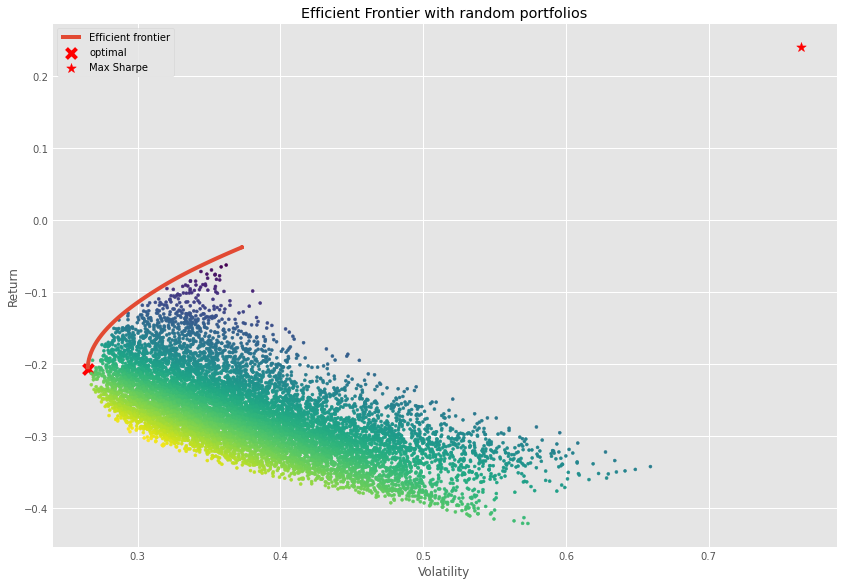

In [32]:
fig, ax = plt.subplots(figsize=(12,8))

ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
pplt.plot_efficient_frontier(ep, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.show()

# VaR - Value at Risk

Value at Risk, or <a href= 'https://pt.wikipedia.org/wiki/Value_at_Risk'> VaR <a/>, is a threshold with a given level that losses will not exceed a certain level.

In [33]:
tqqq.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2022-02-04,58.70,96534410,56.870,60.4100,55.89
2022-02-03,56.74,105575000,59.320,61.0700,56.12
2022-02-02,64.50,100815200,65.220,65.3697,62.35
2022-02-01,63.01,101845800,62.420,63.3500,59.73
2022-01-31,61.83,113751100,57.045,62.0599,56.22
